In [17]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [18]:
import torch
print("Torch: ",torch.__version__)
import torchvision
print("Torchvision: ",torchvision.__version__)
import sklearn
print("sklearn: ",sklearn.__version__)
import sys
print("Python: ",sys.version)

Torch:  1.0.0
Torchvision:  0.2.1
sklearn:  0.20.1
Python:  3.7.2 (default, Dec 29 2018, 06:19:36) 
[GCC 7.3.0]


In [19]:
if torch.cuda.is_available():
    devID=torch.cuda.current_device()
    print("GPU: ",torch.cuda.get_device_name(devID))
else:
    print("Torch Cuda not avaialbe")

Torch Cuda not avaialbe


In [20]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [21]:
from fastai.vision import *
from fastai.metrics import error_rate
from fastai import *

In [22]:
PATH = '../../../../../data/DogBreeds/'

In [23]:
import os
print(os.listdir(PATH))

['train', 'test.zip', 'test', 'labels.csv', 'sample_submission.csv', 'train.zip']


In [24]:
#print(os.listdir(PATH+'test'))

In [25]:
from zipfile import ZipFile
files = os.listdir(PATH)
if not 'train.zip' in files:
    !kaggle competitions download -c dog-breed-identification -p PATH
if not 'train' in files:    
    for file in files:
        with ZipFile(PATH+file, 'r') as zipF:
            zipF.extractall(path=PATH)
            print(file,': Done')
os.listdir(PATH)        

['train',
 'test.zip',
 'test',
 'labels.csv',
 'sample_submission.csv',
 'train.zip']

In [26]:
data = ImageDataBunch.from_csv(PATH, folder='train', ds_tfms=get_transforms(), size=224,suffix='.jpg', bs=32).normalize(imagenet_stats)

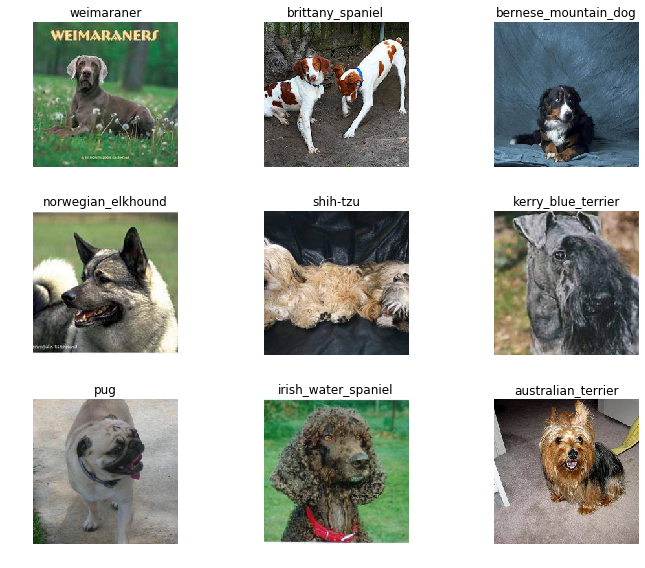

In [27]:
data.show_batch(rows=3, figsize=(10,8), ds_type=DatasetType.Valid)

In [28]:
print(data.classes)
len(data.classes),data.c

['affenpinscher', 'afghan_hound', 'african_hunting_dog', 'airedale', 'american_staffordshire_terrier', 'appenzeller', 'australian_terrier', 'basenji', 'basset', 'beagle', 'bedlington_terrier', 'bernese_mountain_dog', 'black-and-tan_coonhound', 'blenheim_spaniel', 'bloodhound', 'bluetick', 'border_collie', 'border_terrier', 'borzoi', 'boston_bull', 'bouvier_des_flandres', 'boxer', 'brabancon_griffon', 'briard', 'brittany_spaniel', 'bull_mastiff', 'cairn', 'cardigan', 'chesapeake_bay_retriever', 'chihuahua', 'chow', 'clumber', 'cocker_spaniel', 'collie', 'curly-coated_retriever', 'dandie_dinmont', 'dhole', 'dingo', 'doberman', 'english_foxhound', 'english_setter', 'english_springer', 'entlebucher', 'eskimo_dog', 'flat-coated_retriever', 'french_bulldog', 'german_shepherd', 'german_short-haired_pointer', 'giant_schnauzer', 'golden_retriever', 'gordon_setter', 'great_dane', 'great_pyrenees', 'greater_swiss_mountain_dog', 'groenendael', 'ibizan_hound', 'irish_setter', 'irish_terrier', 'iris

(120, 120)

In [29]:
learn = create_cnn(data, models.resnet34, metrics=error_rate)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /home/norvilr/.torch/models/resnet34-333f7ec4.pth
100%|██████████| 87306240/87306240 [00:14<00:00, 6193267.90it/s]


In [30]:
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (rel

In [31]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate


Traceback (most recent call last):
  File "/home/norvilr/anaconda3/envs/torch10/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/home/norvilr/anaconda3/envs/torch10/lib/python3.7/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/norvilr/anaconda3/envs/torch10/lib/python3.7/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/home/norvilr/anaconda3/envs/torch10/lib/python3.7/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
Traceback (most recent call last):
  File "/home/norvilr/anaconda3/envs/torch10/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/home/norvilr/anaconda3/envs/torch10/lib/python3.7/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
BrokenPipeError: [Errno 32] Broken pipe
Traceback (most recent call 

KeyboardInterrupt: 

In [ ]:


learn.save('stage-1')



h